In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#import cufflinks as cf
#cf.go_offline(connected=True)
from scipy import optimize 
from datetime import datetime
from dateutil.relativedelta import relativedelta
%matplotlib inline

try:
  import pandas_datareader.data as web
  import chart_studio as py
except:
  %pip install pip pandas-datareader
  %pip install pip chart_studio
  import pandas_datareader.data as web
  import chart_studio as py
  

GMV Portfolio

In [25]:
class Asset():
  def __init__(self, ticker, name, start, end):
    self.ticker = ticker
    self.name = name
    
    self.start = start
    self.end = end

    # 데이터 불러오기
    self.data = web.get_data_yahoo(self.ticker, self.start, self.end)
    self.date = self.data.index

    self.ratio = 0
    self.price = None
    self.change = None

  def put_price_change(self):
    self.price = self.data['Adj Close']
    self.change = self.price.pct_change().to_list()

  def get_date(self):
    return self.date

  def get_change(self):
    return self.change

  def get_name(self):
    return self.name

In [72]:
class Portfolio_6040():
    def __init__(self, name, assets, ratios, initial_balance, rebalancing_interval):
        self.name = name
        
        # list of class asset elements
        self.assets = assets
       

        # Assert all the dates for assets are equal and set portfolio start, end dates
        dates = [each.get_date() for each in self.assets]
        lendates = [len(each) for each in dates]
        assert len(set(lendates)) == 1
        self.date = dates[0]

        self.ratios = [each / sum(ratios) for each in ratios]

        for i in range(len(self.assets)):
            self.assets[i].put_price_change()

        self.initial_balance = initial_balance    
        self.rebalancing_interval = rebalancing_interval

        self.backtest_df = None
        self.backtest_result_df = None
        self.summary = None



    def backtest(self):
        # 첫 거래일
        balances = []
        
        asset_df = pd.DataFrame()
        lb_asset_df = pd.DataFrame()
        
        # 자산 수익률 계산
        for i in range(len(self.assets)):
            asset_df[i] = self.assets[i].data["Adj Close"]
        
        # Look Back 데이터 자산 수익률 계산
        if self.name == "GMV" or self.name == "All Weather":
            for i in range(len(self.lb_assets)):
                lb_asset_df[i] = self.lb_assets[i].data["Adj Close"]
        
        # 자산별 초기 balance ex[300, 300, 400]
        for i in range(len(self.assets)):
            balance = [self.initial_balance * self.ratios[i]]
            balances.append(balance)
        
        total_balance = [self.initial_balance]  # 초기 밸런스 값 ex)1000
        next_rebalancing = [self.date[0] + relativedelta(months=self.rebalancing_interval)]  # 다음 리밸런싱 기간 ex)2016-04-04
        
        # 이후 거래일
        for i in range(1, len(self.date)):
            total_balance_tmp = 0
        
            #리밸런싱 하는 날
            if self.date[i] >= next_rebalancing[i-1]:
                
                # 다음 리밸런싱 날짜 업데이트
                next_rebalancing.append(next_rebalancing[i-1] + relativedelta(months=self.rebalancing_interval))
                
                
                weight = self.ratios
                    
                for j in range(len(self.assets)):
                    # i시점의 j자산에 대한 밸런스 계산
                    balance = total_balance[i-1] * weight[j] * (1 + self.assets[j].get_change()[i])
                    # 자산별 밸런스 리스트에 추가
                    balances[j].append(balance)
                    # i 시점의 전체 밸런스 계산
                    total_balance_tmp += balances[j][i]
            
            # 리밸런싱 하지 않는 날
            else:
                # 이전 리밸런싱 날짜랑 동일하게
                next_rebalancing.append(next_rebalancing[i-1])
                # Asset 번호
                for j in range(len(self.assets)):
                    try:
                        balances[j].append(balances[j][i-1] * (1 + self.assets[j].get_change()[i]))
                    except:
                        balances[j].append(balances[j][i-1])
                    total_balance_tmp += balances[j][i]
            
            # 밸런스 업데이트
            total_balance.append(total_balance_tmp)

           

        df = pd.DataFrame()
        df['Date'] = self.date
        df.set_index('Date', inplace=True)
        df['Total'] = total_balance

        for i in range(len(self.assets)):
            df[self.assets[i].get_name()] = balances[i]
        
        print('Portfolio Backtest Complete')
        self.backtest_df = df
        
        # 밸런스 DataFrame 반환
        return df
    
    

    def balance_result(self, balance):
        change = [0]
        cum_return = [0]
        prev_high = [0]
        prev_high_tmp = 0
        drawdown = [0]
        mdd = [0]
        mdd_tmp = 0
        CAGR = [0]
        stdev = [0]
        sharpe = [0]

        time_period = (self.date[-1] - self.date[0]).days / 365

        for i in range(1, len(self.date)):
            change.append((balance[i] / balance[i-1] - 1) * 100)
            cum_return.append((balance[i] / balance[0] - 1) * 100)

            if prev_high_tmp < cum_return[i]:
                prev_high_tmp = cum_return[i]
            else:
                prev_high_tmp = prev_high_tmp

            prev_high.append(prev_high_tmp)

            CAGR.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)
            drawdown.append(((cum_return[i] + 100) / (prev_high[i] + 100) - 1) * 100)

            if mdd_tmp > drawdown[i]:
                mdd_tmp = drawdown[i]
            else:
                mdd_tmp = mdd_tmp

            mdd.append(mdd_tmp)
            stdev.append(np.std(change))
            
            if stdev[i] != 0:
                sharpe.append(np.sqrt(252) * np.mean(change) / np.std(change))
            else:
                sharpe.append(0)
                        
        return change, cum_return, prev_high, CAGR, drawdown, mdd, stdev, sharpe

    def backtest_result(self):
        df = pd.DataFrame()
        df['Date'] = self.date
        df.set_index('Date', inplace=True)
        label = ['Change', 'Cum. Return', 'Prev. High', 'CAGR', 'Drawdown', 'MDD', 'St. Dev', 'Sharpe']


        result = dict()

        # 각 자산 i에 대한 밸런스결과 계산
        result['Total'] = self.balance_result(self.backtest_df['Total'].to_list())
        df['Total Balance'] = self.backtest_df['Total'].to_list()
        print('Total Balance Complete')

        # 각 자산별 [Change, ..., Sharpe] 계산
        for j in range(len(label)):
            df[f'Total {label[j]}'] = result['Total'][j]

        self.backtest_result_df = df
        
        return df

    def get_name(self):
        return self.name

    def get_date(self):
        return self.date

    def get_backtest_result(self):
        return self.backtest_result_df

    def get_summary(self):
        # columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'MDD', 'St. Dev', 'Sharpe Ratio']
        
        detail = ''
        for i in range(len(self.assets)):
            name = self.assets[i].get_name()
            if self.name == "GMV":
                percentage = int(self.gmv_weights[i] * 100)
            else:
                percentage = int(self.ratios[i] * 100)

            detail += f'{name} ({percentage}%)'

        self.summary = [detail, self.backtest_result_df['Total Balance'][0], self.backtest_result_df['Total Balance'][-1]]
        
        return self.summary


In [73]:
a1 = Asset("VTI", "STOCK", "2011-01-01", "2020-12-31")
a2 = Asset("EDV", "Bond", "2011-01-01", "2020-12-31")

pfo_6040 = Portfolio_6040("60/40", [a1, a2], [6,4], 1000, 3 )
pfo_6040_backtest_df = pfo_6040.backtest()
pfo_6040_backtest_result_df = pfo_6040.backtest_result()
pfo_6040_summary = pfo_6040.get_summary()

# columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'MDD', 'St. Dev', 'Sharpe Ratio']

pfo_6040_summary

Portfolio Backtest Complete
Total Balance Complete


['STOCK (60%)Bond (40%)', 1000.0, 3760.160196786632]

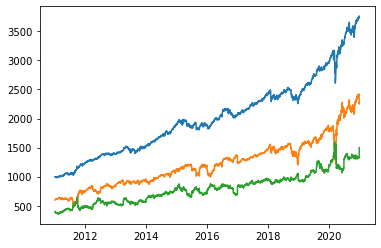

In [70]:
plt.plot(pfo_6040_backtest_df)